In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, make_scorer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


precision_scorer = make_scorer(precision_score, average='weighted')

In [4]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("SampleSubmission.csv")

# Fill missing values for numeric columns
numeric_cols = ['GRE Score', 'TOEFL Score', 'SOP', 'CGPA']
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].median())
test[numeric_cols] = test[numeric_cols].fillna(test[numeric_cols].median())

# One-hot encode the Location column
train = pd.get_dummies(train, columns=['Location'], drop_first=True)
test = pd.get_dummies(test, columns=['Location'], drop_first=True)

# Drop ID column if not needed
train = train.drop(columns=['ID'])
test = test.drop(columns=['ID'])

# Feature Engineering: Example of interaction feature
# --- Binning Age ---
bins = [train['Age'].min()-1, 25, 30, train['Age'].max()+1]
labels = ['Young', 'Mid', 'Senior']
train['Age_bin'] = pd.cut(train['Age'], bins=bins, labels=labels)
test['Age_bin'] = pd.cut(test['Age'], bins=bins, labels=labels)
train = pd.get_dummies(train, columns=['Age_bin'], drop_first=True)
test = pd.get_dummies(test, columns=['Age_bin'], drop_first=True)

# --- Quantile Binning GRE Score, TOEFL Score, CGPA ---
train['GRE_bin'] = pd.qcut(train['GRE Score'], q=4, labels=False)
test['GRE_bin'] = pd.qcut(test['GRE Score'], q=4, labels=False)
train['TOEFL_bin'] = pd.qcut(train['TOEFL Score'], q=4, labels=False)
test['TOEFL_bin'] = pd.qcut(test['TOEFL Score'], q=4, labels=False)
train['CGPA_bin'] = pd.qcut(train['CGPA'], q=4, labels=False)
test['CGPA_bin'] = pd.qcut(test['CGPA'], q=4, labels=False)

# --- Composite Academic Score ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
academic_features = ['GRE Score', 'TOEFL Score', 'CGPA']
train_scaled = scaler.fit_transform(train[academic_features])
test_scaled = scaler.transform(test[academic_features])
train_scaled = pd.DataFrame(train_scaled, columns=[f'{col}_scaled' for col in academic_features], index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=[f'{col}_scaled' for col in academic_features], index=test.index)
train = pd.concat([train, train_scaled], axis=1)
test = pd.concat([test, test_scaled], axis=1)
train['Academic_Score'] = train[[f'{col}_scaled' for col in academic_features]].mean(axis=1)
test['Academic_Score'] = test[[f'{col}_scaled' for col in academic_features]].mean(axis=1)

# --- Interaction Feature ---
train['GRE_TOEFL_interaction'] = train['GRE Score'] * train['TOEFL Score']
test['GRE_TOEFL_interaction'] = test['GRE Score'] * test['TOEFL Score']

# --- Outlier Flagging (Example for GRE Score) ---
train['GRE_outlier'] = ((train['GRE Score'] < train['GRE Score'].quantile(0.01)) | 
                        (train['GRE Score'] > train['GRE Score'].quantile(0.99))).astype(int)
test['GRE_outlier'] = ((test['GRE Score'] < test['GRE Score'].quantile(0.01)) | 
                       (test['GRE Score'] > test['GRE Score'].quantile(0.99))).astype(int)


X = train.drop(columns=['Admitted'])
y = train['Admitted']


In [7]:
rf_model = RandomForestClassifier(
    n_estimators= 289,
    max_depth= 30,
    min_samples_split= 5,
    min_samples_leaf= 1,
    max_features= None,
    random_state=42
)

cat_model = CatBoostClassifier(
    depth= 9,
    learning_rate= 0.04080289243388582,
    iterations= 137,
    l2_leaf_reg= 5.337757222053476,
    bagging_temperature= 0.5180609232937734,
    verbose=0, 
    random_state=42
)

xgb_model = XGBClassifier(
    max_depth= 5,
    learning_rate= 0.026702342050870347,
    n_estimators= 218,
    subsample= 0.7787723853194979,
    colsample_bytree= 0.7710904649480395,
    gamma= 1.2850994589333046e-05,
    random_state=42,
)

lgbm_model = LGBMClassifier(
    num_leaves= 22,
    max_depth= 5,
    learning_rate= 0.03996298076766112,
    n_estimators= 228,
    min_child_samples= 12,
    subsample= 0.8519993903232219,
    colsample_bytree= 0.8458067773417671,
    random_state=42
)

# Create a StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each base model using cross-validation and print weighted precision scores
rf_cv_scores = cross_val_score(rf_model, X, y, cv=skf, scoring=precision_scorer)
cat_cv_scores = cross_val_score(cat_model, X, y, cv=skf, scoring=precision_scorer)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=skf, scoring=precision_scorer)
lgbm_cv_scores = cross_val_score(lgbm_model, X, y, cv=skf, scoring=precision_scorer)

print("RandomForest CV Weighted Precision: {:.4f} ± {:.4f}".format(rf_cv_scores.mean(), rf_cv_scores.std()))
print("CatBoost CV Weighted Precision: {:.4f} ± {:.4f}".format(cat_cv_scores.mean(), cat_cv_scores.std()))
print("XGBoost CV Weighted Precision: {:.4f} ± {:.4f}".format(xgb_cv_scores.mean(), xgb_cv_scores.std()))
print("LightGBM CV Weighted Precision: {:.4f} ± {:.4f}".format(lgbm_cv_scores.mean(), lgbm_cv_scores.std()))

c:\Users\Timmy-afolami\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Timmy-afolami\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Timmy-afolami\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Timmy-afolami\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Timmy-afolami\anaconda3\Lib\subprocess.py", line 1538, in _execute_child


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1916, number of negative: 964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1748
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665278 -> initscore=0.686904
[LightGBM] [Info] Start training from score 0.686904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [9]:
# Build a stacking ensemble with the four models as base estimators.
estimators = [
    ('rf', rf_model),
    ('cat', cat_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=500, random_state=42),
    cv=skf,          # use the same cross-validation strategy for stacking
    passthrough=False,  # set to True to include original features for meta-model training
    n_jobs=-1
)

# Evaluate the stacking ensemble using cross-validation
stacking_cv_scores = cross_val_score(stacking_model, X, y, cv=skf, scoring=precision_scorer)
print("Stacking Ensemble CV Weighted Precision: {:.4f} ± {:.4f}".format(
    stacking_cv_scores.mean(), stacking_cv_scores.std()))

Stacking Ensemble CV Weighted Precision: 0.8471 ± 0.0090


In [11]:
# Build a stacking ensemble with the four models as base estimators.
estimators = [
    ('rf', rf_model),
    ('cat', cat_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=skf,          # use the same cross-validation strategy for stacking
    passthrough=False,  # set to True to include original features for meta-model training
    n_jobs=-1
)

# Evaluate the stacking ensemble using cross-validation
stacking_cv_scores = cross_val_score(stacking_model, X, y, cv=skf, scoring=precision_scorer)
print("Stacking Ensemble CV Weighted Precision: {:.4f} ± {:.4f}".format(
    stacking_cv_scores.mean(), stacking_cv_scores.std()))

Stacking Ensemble CV Weighted Precision: 0.8621 ± 0.0147


In [12]:
stacking_model.fit(X, y)

# Predict on the test set
test_predictions = stacking_model.predict(test)

# Prepare submission
submission = sample_submission.copy()
submission['Admitted'] = test_predictions
submission.to_csv('trial_1.csv', index=False)
print("Stacking ensemble submission saved as trial.csv")

Stacking ensemble submission saved as trial.csv


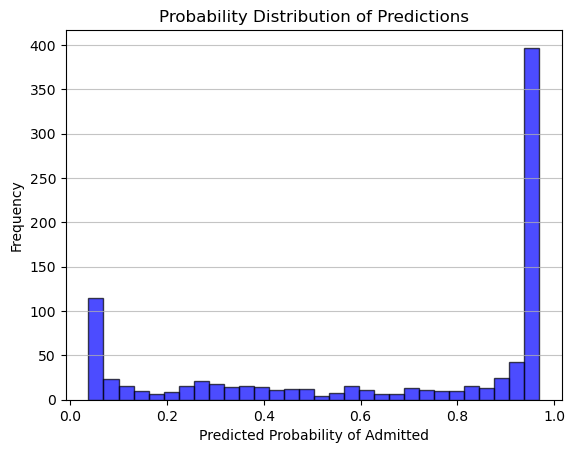

In [14]:
# Predict probabilities on the test set
test_predictions_proba = stacking_model.predict_proba(test)

# Show the probability distribution
import matplotlib.pyplot as plt
plt.hist(test_predictions_proba[:, 1], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Probability Distribution of Predictions')
plt.xlabel('Predicted Probability of Admitted')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [16]:
# Set threshold for predictions
threshold = 0.4
test_predictions_binary = (test_predictions_proba[:, 1] >= threshold).astype(int)

# Prepare submission with binary predictions
submission_binary = sample_submission.copy()
submission_binary['Admitted'] = test_predictions_binary
submission_binary.to_csv('trial_binary_submission1.csv', index=False)
print("Binary submission saved as trial_binary_submission.csv")

Binary submission saved as trial_binary_submission.csv
